In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/onlineretail/OnlineRetail.csv


# Imports

In [2]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

## Load and Examine Data

In [3]:
retail = pd.read_csv('../input/onlineretail/OnlineRetail.csv', encoding = 'unicode_escape')
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Preprocessing

There is a little cleanup, we need to do. First, some of the descriptions have spaces that need to be removed. We’ll also drop the rows that don’t have invoice numbers and remove the credit transactions (those with invoice numbers containing C).

In [4]:
retail['Description'] = retail['Description'].str.strip()
retail.dropna(axis=0, subset=['InvoiceNo'], inplace=True)
retail['InvoiceNo'] = retail['InvoiceNo'].astype('str')
retail = retail[~retail['InvoiceNo'].str.contains('C')]

## Consolidate Items into 1 Transaction Per Row

After the cleanup, we need to consolidate the items into 1 transaction per row with each product 1 hot encoded. For the sake of keeping the data set small, I’m only looking at sales for France. However, in additional code below, I will compare these results to sales from Germany. Further country comparisons would be interesting to investigate.

In [5]:
basket = (retail[retail['Country'] =="France"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

In [6]:
basket.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Postprocessing

There are a lot of zeros in the data but we also need to make sure any positive values are converted to a 1 and anything less the 0 is set to 0. This step will complete the one hot encoding of the data and remove the postage column (since that charge is not one we wish to explore):

In [7]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)

## Generate Frequent Itemsets

Now that the data is structured properly, we can generate frequent item sets that have a support of at least 7% (this number was chosen so that I could get enough useful examples):

In [8]:
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)

## Building Association Rules Using Frequent Itemset

The final step is to generate the rules with their corresponding support, confidence and lift:

In [9]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.102041,0.096939,0.073980,0.725000,7.478947,0.064088,3.283859
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.096939,0.102041,0.073980,0.763158,7.478947,0.064088,3.791383
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.096939,0.094388,0.079082,0.815789,8.642959,0.069932,4.916181
3,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.094388,0.096939,0.079082,0.837838,8.642959,0.069932,5.568878
4,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED),0.102041,0.094388,0.073980,0.725000,7.681081,0.064348,3.293135


## Visualizing Relationship between Support, Confidence and Support

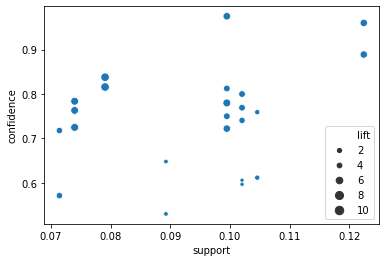

In [10]:
# Import seaborn under its standard alias
import seaborn as sns
import matplotlib.pyplot as plt


# Generate scatterplot using support and confidence
sns.scatterplot(x = "support", y = "confidence", 
                size = "lift", data = rules)
plt.show()


## Filtering Rules Dataframe

Now, the tricky part is figuring out what this tells us. For instance, we can see that there are quite a few rules with a high lift value which means that it occurs more frequently than would be expected given the number of transaction and product combinations. We can also see several where the confidence is high as well. This part of the analysis is where the domain knowledge will come in handy.

We can filter the dataframe using standard pandas code. In this case, look for a large lift (6) and high confidence (.8):

In [11]:
rules[ (rules['lift'] >= 6) &
       (rules['confidence'] >= 0.8) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.096939,0.094388,0.079082,0.815789,8.642959,0.069932,4.916181
3,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.094388,0.096939,0.079082,0.837838,8.642959,0.069932,5.568878
17,(SET/6 RED SPOTTY PAPER PLATES),(SET/20 RED RETROSPOT PAPER NAPKINS),0.127551,0.132653,0.102041,0.800000,6.030769,0.085121,4.336735
18,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.137755,0.127551,0.122449,0.888889,6.968889,0.104878,7.852041
19,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.127551,0.137755,0.122449,0.960000,6.968889,0.104878,21.556122
20,"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...",(SET/6 RED SPOTTY PAPER PLATES),0.102041,0.127551,0.099490,0.975000,7.644000,0.086474,34.897959
21,"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...",(SET/6 RED SPOTTY PAPER CUPS),0.102041,0.137755,0.099490,0.975000,7.077778,0.085433,34.489796
22,"(SET/6 RED SPOTTY PAPER CUPS, SET/6 RED SPOTTY...",(SET/20 RED RETROSPOT PAPER NAPKINS),0.122449,0.132653,0.099490,0.812500,6.125000,0.083247,4.625850


## Further Analysis
 
You may want to look at how much opportunity there is to use the popularity of one product to drive sales of another. For instance, we can see that we sell 340 Green Alarm clocks but only 316 Red Alarm Clocks so maybe we can drive more Red Alarm Clock sales through recommendations?

In [12]:
print("ALARM CLOCK BAKELIKE GREEN : ",basket['ALARM CLOCK BAKELIKE GREEN'].sum())
print("ALARM CLOCK BAKELIKE RED : ",basket['ALARM CLOCK BAKELIKE RED'].sum())

ALARM CLOCK BAKELIKE GREEN :  340.0
ALARM CLOCK BAKELIKE RED :  316.0


## Popular Product Combinations by Country

In [13]:
basket2 = (retail[retail['Country'] =="Germany"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))


basket2.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,...,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
basket_sets2 = basket2.applymap(encode_units)
basket_sets2.drop('POSTAGE', inplace=True, axis=1)
frequent_itemsets2 = apriori(basket_sets2, min_support=0.05, use_colnames=True)
rules2 = association_rules(frequent_itemsets2, metric="lift", min_threshold=1)


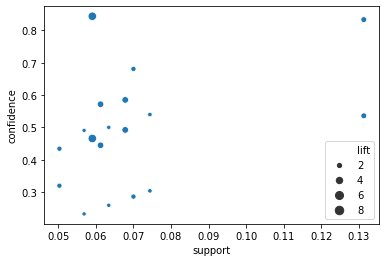

In [15]:
# Import seaborn under its standard alias
import seaborn as sns
import matplotlib.pyplot as plt


# Generate scatterplot using support and confidence
sns.scatterplot(x = "support", y = "confidence", 
                size = "lift", data = rules2)
plt.show()


In [16]:
rules2[ (rules2['lift'] >= 4) &
        (rules2['confidence'] >= 0.5)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN WOODLAND ANIMALS),0.115974,0.137856,0.067834,0.584906,4.242887,0.051846,2.076984
6,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.107221,0.137856,0.061269,0.571429,4.145125,0.046488,2.011670
10,(RED RETROSPOT CHARLOTTE BAG),(WOODLAND CHARLOTTE BAG),0.070022,0.126915,0.059081,0.843750,6.648168,0.050194,5.587746


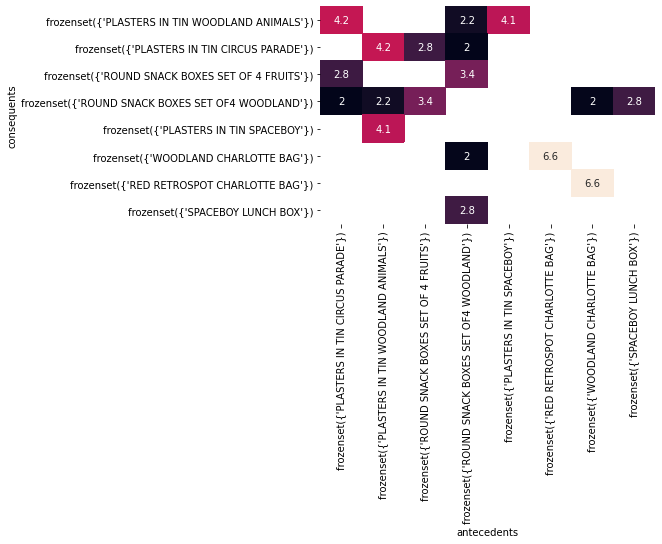

In [17]:
# Import seaborn under its standard alias
import seaborn as sns
import matplotlib.pyplot as plt

# Transform the DataFrame of rules into a matrix using the lift metric

pivot = rules2.pivot(index = 'consequents', columns = 'antecedents', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off

sns.heatmap(pivot, annot = True, cbar=False)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()


## References

https://pbpython.com/market-basket-analysis.html